# Object Detection

In [1]:
import time
import requests
import cv2
import numpy as np
import os
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

import cv2
sys.path.append("..")
from object_detection.utils import ops as utils_ops
%matplotlib inline
from utils import label_map_util
from utils import visualization_utils as vis_util

# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

## Download Model

# opener = urllib.request.URLopener()
# opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
# tar_file = tarfile.open(MODEL_FILE)
# for file in tar_file.getmembers():
#   file_name = os.path.basename(file.name)
#   if 'frozen_inference_graph.pb' in file_name:
#     tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Helper code

def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [2]:
IMAGE_SIZE = (12, 8)

In [3]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [4]:
category_index

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

In [5]:
def image_capture(url):
    img_resp = requests.get(url)
    img_arr = np.array(bytearray(img_resp.content), dtype=np.uint8)
    img = cv2.imdecode(img_arr, -1)
    cv2.imwrite('test_images\camera_test_images\image1.jpg',img)

In [6]:
## focal length of J7 prime without zoom(f) = 3.5mm
## sensor height of J7 prime(sh) = 3.49mm
## distance of A from Camera = f(mm)*real_height(mm)*image_height(px)
##                             ______________________________________
##                                  object_height(px)*sh(mm)


def camera_distance_cm(real_height,image_height,object_height):    #real_height in mm #image_height in px #object_height in px
  f = 3.5
  sh = 3.49
  distance = (f*real_height*image_height)/(object_height*sh)
  return (distance+40)/1000                  ##returns distance in meters

<h1>Plural Function and Objects Counter</h1>

In [7]:
import inflect
p = inflect.engine()
def plural(word,count):
  return p.plural(word,count)

<h1> Simple Sentence Function </h1>

In [8]:
def simple_sentence(objects,info):    ####info 2D array ==> [['bottle', 'centre', 0]]
                                      ####objects collection counter ==> Counter({'bottle': 1})
  
  #sentence 1
  sentence = "In your view, there "
  if len(info) == 1:
    sentence += "is "
    for i in objects:
      sentence += str(objects[i])+" "+plural(i, objects[i])+", "
  else:
    sentence += "are "
    j = 0
    for i in objects:
      if j == 0 and objects[i]==1:
        sentence = sentence[:-4]
        sentence +="is "
        sentence += str(objects[i])+" "+plural(i, objects[i])+", "
        j += 1
      else:    
        if j==len(objects)-2:
          sentence += str(objects[i])+" "+plural(i, objects[i])+" and "
        else:
          sentence += str(objects[i])+" "+plural(i, objects[i])+", "  
        j+=1
  sentence = sentence[:-2]
  sentence += ". "
  j=0
  
  #sentence 2
  for i in objects:      
    if objects[i]==1:
      sentence += "The "+ i + " is to your "
      for k in range(objects[i]):
        sentence += info[j][1]
        j+=1
      sentence += ". "
    else:
      sentence += "The "+ plural(i,objects[i]) + " are to your "      
      for k in range(objects[i]):
        sentence += info[j][1]+", "
        j+=1
      sentence = sentence[:-2]
      sentence += ". "
  return sentence

<h1>Detailed Sentence Function</h1>

In [9]:
def detailed_sentence(objects,info):    ####info 2D array ==> [['bottle', 'centre', 0]]
                                      ####objects collection counter ==> Counter({'bottle': 1})
  
  #sentence 1
  sentence = "In your view, there "
  if len(info) == 1:
    sentence += "is "
    for i in objects:
      sentence += str(objects[i])+" "+plural(i, objects[i])+", "
  else:
    sentence += "are "
    j = 0
    for i in objects:
      if j == 0 and objects[i]==1:
        sentence = sentence[:-4]
        sentence +="is "
        sentence += str(objects[i])+" "+plural(i, objects[i])+", "
        j += 1
      else:    
        if j==len(objects)-2:
          sentence += str(objects[i])+" "+plural(i, objects[i])+" and "
        else:
          sentence += str(objects[i])+" "+plural(i, objects[i])+", "  
        j+=1
  sentence = sentence[:-2]
  sentence += ". "
  j=0
  
  #sentence 2
  for i in objects:      
    if objects[i]==1:
      sentence += " The "+ i + " is to your "
      direction = ""      
      for k in range(objects[i]):
        sentence += info[j][1]
        direction += str(info[j][2])+", "
        j+=1
      sentence += ". "
      sentence = sentence[:-2]
      sentence += " at an approximate distance of "+direction
      sentence = sentence[:-2]+" meters."
    else:
      sentence += " The "+ plural(i,objects[i]) + " are to your "
      direction = ""
      for k in range(objects[i]):
        sentence += info[j][1]+", "
        direction += str(info[j][2])+", "
        j+=1
      sentence = sentence[:-2]
      sentence += ". "
      sentence = sentence[:-2]
      sentence += " at an approximate distance of "+direction
      sentence = sentence[:-2]+" meters."    
  return sentence

Next Image
In your view, there is 1 person, 1 backpack. The person is to your right. The backpack is to your right. 
In your view, there is 1 person, 1 backpack.  The person is to your right at an approximate distance of 7 meters. The backpack is to your right at an approximate distance of 2 meters.
Processing Time : 9.30 seconds
Next Image
In your view, there is 1 person. The person is to your right. 
In your view, there is 1 person.  The person is to your right at an approximate distance of 2 meters.
Processing Time : 9.27 seconds
Next Image
In your view, there is 1 person, 1 backpack. The person is to your right. The backpack is to your right. 
In your view, there is 1 person, 1 backpack.  The person is to your right at an approximate distance of 6 meters. The backpack is to your right at an approximate distance of 2 meters.
Processing Time : 9.24 seconds


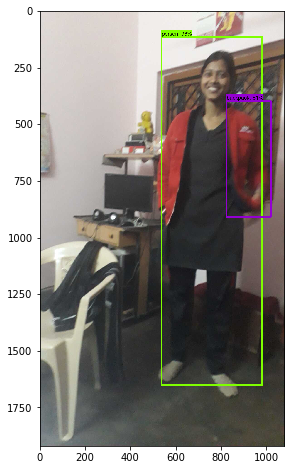

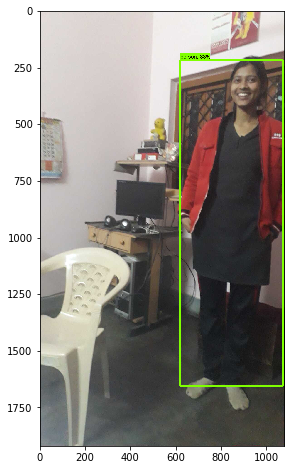

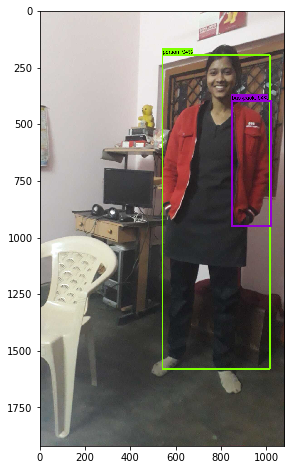

In [14]:
url = "http://192.168.43.1:8080/shot.jpg"
z = 1

while z<4:
  
  start = time.time()
  
  image_capture(url)
  image = Image.open("test_images\camera_test_images\image1.jpg")
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)

  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  
  dim = image_np.shape

  mapped = list(zip(output_dict['detection_classes'], output_dict['detection_scores'],output_dict['detection_boxes']))

  real_height_array = [0,1650, 1600, 2362, 1700, 18970, 
  3200, 4366, 4520, 1371, 2133,
  1524, 0, 914, 4876, 457, 
  121, 250, 622, 1600, 1371,
  1219, 2743, 1524, 1371, 5500,
  0, 1800, 914, 0, 0,
  1450, 300, 670, 250, 1700,
  1530, 220, 650, 1066, 317,
  750, 2133, 711, 228, 0,
  150, 101, 177, 180, 157,
  254, 177, 101, 101, 80,
  127, 150, 150, 406, 76,
  203, 508, 914, 609, 914,
  0, 1219, 0, 0, 50,
  0, 400, 396, 101, 203,
  177, 140, 254, 406, 203,
  914, 1778, 0, 228, 304,
  762, 177, 600, 228, 135]

  global object_array
  object_array = []
  array = []
  for j,k,l in mapped:
    x = ((l[1]+l[3])/2)*dim[1]    ##768 for test image
    y = ((l[0]+l[2])/2)*dim[0]   ##461 for test image

    #l[0] --> ymin, 
    #l[1] --> xmin , 
    #l[2] --> ymax, 
    #l[3] --> ymax, 
    #x --> width, 
    #y --> height

    check0 = 0
    check1 = dim[1]/3
    check2 = (dim[1]/3)*2
    check3 = dim[1]
    name = category_index[j]['name']
    if k>= 0.5:
      array.append(name)
      distance = int(round(camera_distance_cm(real_height_array[j],dim[0],(l[2]-l[0])*dim[0])))
      #print(l[0]*dim[1], l[1]*dim[1], l[2]*dim[1], l[3]*dim[1])
      if x >= check0 and x < check1:
        single_object = [name,"left",round(distance)]
        #print(j,k,name,x,y,"left",(l[2]-l[0])*dim[0], distance)
      elif x >= check1 and x < check2:
        single_object = [name,"centre",distance]
        #print(j,k,name,x,y,"centre",(l[2]-l[0])*dim[0], distance)
      else:
        single_object = [name,"right",distance]
        #print(j,k,name,x,y,"right",(l[2]-l[0])*dim[0], distance)
      object_array.append(single_object)
  print("Next Image")
  info = sorted(object_array)
  
  from collections import Counter
  objects = Counter(array)  
  ########################################################
  simple = simple_sentence(objects,info)
  detailed = detailed_sentence(objects,info)
  
  if simple == "In your view, there ar. ":
    simple = "No objects detected, please try a different view."
    detailed = "No objects detected, please try a different view."
  else:
    pass
  
  
  print(simple)
  print(detailed)
  end = time.time()
  print("Processing Time : " + str(end-start)[:-13]+" seconds")
  #######  Initializing Text to Speech Engine    #########
  
  import pyttsx3
  engine = pyttsx3.init()
  voices = engine.getProperty('voices')
  engine.setProperty('voice', voices[0].id)  # voices
  engine.say(simple)
  engine.runAndWait()
  
  engine = pyttsx3.init()
  voices = engine.getProperty('voices')
  engine.setProperty('voice', voices[0].id)  # voices
  engine.say(detailed)
  engine.runAndWait()
  #time.sleep(10)
  z+=1

In [ ]:
for i in objects:
    print (plural(i, objects[i]),objects[i])

In [ ]:
import pyttsx3
engine = pyttsx3.init()
voices = engine.getProperty('voices')
engine.setProperty('voice', voices[0].id)  # changes the voice
engine.say('In your view, there is 1 bus, 3 people and 1 truck. The bus is to your centre. The people are to your left, left, left. The truck is to your right.')
engine.runAndWait()

In [ ]:
a = "awd"
b = "awd"
if a==b:
  print (True)

In [ ]:
str(time.time())[:-4]